In [2]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, Subset
import torch

In [3]:

#1 Feature
"""


def load_data(data, window_size):
    splits = len(data)//window_size
    data = data[:splits*window_size]
    data = data.reshape(-1,window_size)
    #print(np.shape(data))
    return data

def del_nan_element(data_with_nan):
    nan_val = np.isnan(data_with_nan)
    return data_with_nan[nan_val==False]

def concatenate_data_from_BSD_state(folders, data_path, features_of_interest, window_size):
    x_data_concatenated = None
    y_data_concatenated = None
    
    first = True
    for BSD_path in folders.keys(): #folder path
        for file_path in folders[BSD_path]: #file path 
            
            path_BSD_file = os.path.join(data_path, BSD_path, file_path) # concatenate the folder and file path
            
            #in first iteration get a list if all features
            if first == True:
                features = get_features(path_BSD_file)
            
            #load data from files in shape [window_number, 1, window_size]
            data_BSD_file = np.genfromtxt(path_BSD_file, dtype = np.dtype('d'), delimiter=',')[1:,:] #write csv in numpy
            data_BSD_file = data_BSD_file[:,features.index(features_of_interest)]
            data_BSD_file = np.nan_to_num(data_BSD_file)
            #data_BSD_file = del_nan_element(data_BSD_file)
            data_BSD_file = load_data(data_BSD_file, window_size)
            data_BSD_file = np.expand_dims(data_BSD_file, axis = 1)
            
            #rewrite labels as BSD_condition_1 = 0, BSD_condition_2 = 1, BSD_condition_3 = 2, BSD_condition_P1 = 3
            label = BSD_path[-2]
            if label == "P":
                label = int(3)
            else:
                label =int(int(label)-1)
            
            #concatenate the data from each file in one numpy array
            if  first == True:
                x_data_concatenated = np.copy(data_BSD_file)
                y_data_concatenated = np.copy(np.asarray([label]*np.shape(data_BSD_file)[0]))
                first = False
            else:
                x_data_concatenated = np.concatenate((x_data_concatenated, data_BSD_file), axis=0)
                y_data_concatenated = np.concatenate((y_data_concatenated,np.asarray([label]*np.shape(data_BSD_file)[0])), axis=0)
            print(np.shape(x_data_concatenated), np.shape(y_data_concatenated))
    
    #generate torch array
    n_samples = np.shape(x_data_concatenated)[0]
    x_data = torch.from_numpy(x_data_concatenated)
    y_data = torch.from_numpy(y_data_concatenated)
    
    return n_samples, x_data, y_data
"""

'\n\n\ndef load_data(data, window_size):\n    splits = len(data)//window_size\n    data = data[:splits*window_size]\n    data = data.reshape(-1,window_size)\n    #print(np.shape(data))\n    return data\n\ndef del_nan_element(data_with_nan):\n    nan_val = np.isnan(data_with_nan)\n    return data_with_nan[nan_val==False]\n\ndef concatenate_data_from_BSD_state(folders, data_path, features_of_interest, window_size):\n    x_data_concatenated = None\n    y_data_concatenated = None\n    \n    first = True\n    for BSD_path in folders.keys(): #folder path\n        for file_path in folders[BSD_path]: #file path \n            \n            path_BSD_file = os.path.join(data_path, BSD_path, file_path) # concatenate the folder and file path\n            \n            #in first iteration get a list if all features\n            if first == True:\n                features = get_features(path_BSD_file)\n            \n            #load data from files in shape [window_number, 1, window_size]\n         

In [4]:
"""

def load_data(data, window_size):

    Split data in windows of equal size
    
    INPUT:
    @data: data numpy array of shape [elements per file, features]
    @window: number of elements per window
    
    OUTPUT
    @data: data numpy array of shape [number_of_windows, elements per window, features]

    splits = np.shape(data)[0]//window_size # number of splits
    data = data[:splits*window_size] #cut off end of array such that array can be split equaly
    data = data.reshape((splits,-1,np.shape(data)[1])) #split array in windows
    return data


"""
def load_data(data, window_size, overlap_size):
    """
    Split data in windows of equal size
    
    INPUT:
    @data: data numpy array of shape [elements per file, features]
    @window: number of elements per window
    
    OUTPUT
    @data: data numpy array of shape [number_of_windows, elements per window, features]
    """
    num_windows = (data.shape[0] - window_size) // (window_size - overlap_size) + 1
    overhang = data.shape[0] - (num_windows*window_size - (num_windows-1)*overlap_size)

    return data






In [5]:
def del_nan_element(data_with_nan):
    """
    Delete all elements in the data which have any nan valued feature
    
    INPUT:
    @data_with_nan: data numpy array containing nan_values
    
    OUTPUT
    @data_with_nan: data numpy array inlcuding just elements per window which do have no nan_vaues in any feature
    """
    nan_val = np.isnan(data_with_nan) #mask for all nan_elements as 2d array [elements_per_window, features]
    nan_val = np.any(nan_val,axis = 1) #mask for all nan_rows as 1d array [elements_per_window]
    return data_with_nan[nan_val==False]

In [6]:
def create_folder_dictionary(list_of_train_BSD_states, list_of_test_BSD_states, data_path):
    """
    Create a dictionaty for testing and training containing folder names as keys and files as values
    
    INPUT:
    @list_of_train_BSD_states: list containing the training BSD states as string
    @list_of_test_BSD_states: list containing the testing BSD states as string
    @data_path: data directory containing folders for each BSD state
    
    OUTPUT
    @training_folders: dictionary folders and keys for training
    @testing_folders: dictionary folders and keys for testing
    """
    
    data_path = data_path
    training_folders = {}
    testing_folders = {}
    
    #Sorting the individual folders by findinding the BSD_states in the folder names
    for data_path_element in os.listdir(data_path):
        if any(element in data_path_element for element in list_of_train_BSD_states): 
            training_folders[data_path_element]  = os.listdir(os.path.join(data_path,data_path_element))
        elif any(element in data_path_element for element in list_of_test_BSD_states): 
            testing_folders[data_path_element] = os.listdir(os.path.join(data_path,data_path_element))
    return training_folders, testing_folders

In [7]:
def get_features(path):
    """
    Creates a list of all feature names
    INPUT:
    @path: path to any BSD file since the features are the same for all files
    
    OUTPUT
    @features: list of features:
    ['C:s_ist/X', 'C:s_soll/X', 'C:s_diff/X', 'C:v_(n_ist)/X', 'C:v_(n_soll)/X', 'C:P_mech./X', 'C:Pos._Diff./X',
    'C:I_ist/X', 'C:I_soll/X', 'C:x_bottom', 'C:y_bottom', 'C:z_bottom', 'C:x_nut', 'C:y_nut', 'C:z_nut',
    'C:x_top', 'C:y_top', 'C:z_top', 'D:s_ist/X', 'D:s_soll/X', 'D:s_diff/X', 'D:v_(n_ist)/X', 'D:v_(n_soll)/X',
    'D:P_mech./X', 'D:Pos._Diff./X', 'D:I_ist/X', 'D:I_soll/X', 'D:x_bottom', 'D:y_bottom', 'D:z_bottom',
    'D:x_nut', 'D:y_nut', 'D:z_nut', 'D:x_top', 'D:y_top', 'D:z_top', 'S:x_bottom', 'S:y_bottom', 'S:z_bottom',
    'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]',
    'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]',
    'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]']
    """
    
    with open(path, 'r') as file:
        csvreader = csv.reader(file)
        features = next(csvreader)
    return features

In [8]:
def concatenate_data_from_BSD_state(folders, data_path, features_of_interest, window_size):
    """
    Concatenates all the windowed data from each file to one big torch array
    INPUT:
    @folders: dictionary containing folders (as keys) and files (as values) to downloaded
    @data_path: data directory containing folders for each BSD state
    @features_of_interest: list of features which should be included for training
    @window_size: number of elements per widow
    
    OUTPUT:
    @n_samples: number of total elements from all included files
    @x_data: torch array containing all the data elements 
    @y_data: torch array containing the labels for all elements
    """
    
    
    # arrays to collect data and label
    x_data_concatenated = None
    y_data_concatenated = None
    
    
    iterator = 0
    first = True
    
    
    for BSD_path in folders.keys(): #folder path
        for file_path in folders[BSD_path]: #file path 
            path_BSD_file = os.path.join(data_path, BSD_path, file_path) # concatenate the data_path, folder and file path
            
            #in first iteration get a list if all features
            if first == True:
                features = get_features(path_BSD_file)
            
            data_BSD_file = np.genfromtxt(path_BSD_file, dtype = np.dtype('d'), delimiter=',')[1:,:] #write csv in numpy
            feature_index_list = np.where(np.isin(features, features_of_interest)) #get index for all features of interest
            data_BSD_file = data_BSD_file[:,feature_index_list] #slice numpy array such that just features of interest are included
            data_BSD_file = np.squeeze(data_BSD_file, axis = 1) # one unnecessary extra dimension was created while slicing
            data_BSD_file = del_nan_element(data_BSD_file) #delete all elements with any nan feature
            data_BSD_file = load_data(data_BSD_file, window_size) #window the data
            data_BSD_file = np.swapaxes(data_BSD_file,1,2) #swap axes for CNN
            
            
            
            #rewrite labels as BSD_condition_1 = 0, BSD_condition_2 = 1, BSD_condition_3 = 2, BSD_condition_P1 = 3
            label = BSD_path[-2]
            if label == "P":
                label = int(3)
            else:
                label =int(int(label)-1)
            
            
            
            #concatenate the data from each file in one numpy array
            if  first == True: #overwrite variable
                x_data_concatenated = np.copy(data_BSD_file)
                y_data_concatenated = np.copy(np.asarray([label]*np.shape(data_BSD_file)[0]))
                first = False
            else: #concatenate data numpy arrays
                x_data_concatenated = np.concatenate((x_data_concatenated, data_BSD_file), axis=0)
                y_data_concatenated = np.concatenate((y_data_concatenated,np.asarray([label]*np.shape(data_BSD_file)[0])), axis=0)
            
            
            iterator +=1
            print(f"{iterator}/{len(folders.keys())*len(folders[list(folders.keys())[0]])} folders downloaded")
            print(f"downloaded folder: {BSD_path}/{file_path}")
            print(f"Shape of collected datafram: X_shape: {np.shape(x_data_concatenated)}, Y_shape: {np.shape(y_data_concatenated)}")
    
    #generate torch array
    n_samples = np.shape(x_data_concatenated)[0]
    x_data = torch.from_numpy(x_data_concatenated)
    y_data = torch.from_numpy(y_data_concatenated)
    
    return n_samples, x_data, y_data

In [40]:
class TimeSeriesData_Single_Feature(Dataset):
    def __init__(self):
        window_size = 1024
        features_of_interest = ['C:s_ist/X', 'C:s_soll/X', 'C:s_diff/X', 'C:v_(n_ist)/X', 'C:v_(n_soll)/X', 'C:P_mech./X', 'C:Pos._Diff./X',
    'C:I_ist/X', 'C:I_soll/X', 'C:x_bottom', 'C:y_bottom', 'C:z_bottom', 'C:x_nut', 'C:y_nut', 'C:z_nut',
    'C:x_top', 'C:y_top', 'C:z_top', 'D:s_ist/X', 'D:s_soll/X', 'D:s_diff/X', 'D:v_(n_ist)/X', 'D:v_(n_soll)/X',
    'D:P_mech./X', 'D:Pos._Diff./X', 'D:I_ist/X', 'D:I_soll/X', 'D:x_bottom', 'D:y_bottom', 'D:z_bottom',
    'D:x_nut', 'D:y_nut', 'D:z_nut', 'D:x_top', 'D:y_top', 'D:z_top', 'S:x_bottom', 'S:y_bottom', 'S:z_bottom',
    'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]',
    'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]',
    'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]']
        number_of_files_per_BDS_state = 10
        list_of_train_BSD_states = ["BSD_31", "BSD_21", "BSD_11", "BSD_P1"]
        list_of_test_BSD_states = ["BSD_32", "BSD_22", "BSD_12", "BSD_P2"]
        data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
        
        training_folders, testing_folders = create_folder_dictionary(list_of_train_BSD_states, list_of_test_BSD_states, data_path)
        
        self.n_samples, self.x_data, self.y_data = concatenate_data_from_BSD_state(training_folders, data_path, features_of_interest, window_size)
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    
    
    
    
dataset = TimeSeriesData_Single_Feature()



    

1/120 folders downloaded
downloaded folder: NR03_20200424_PGS_31_BSD_11/063_2020_04_24.csv
Shape of collected datafram: X_shape: (16, 49, 1024), Y_shape: (16,)
2/120 folders downloaded
downloaded folder: NR03_20200424_PGS_31_BSD_11/064_2020_04_24.csv
Shape of collected datafram: X_shape: (32, 49, 1024), Y_shape: (32,)
3/120 folders downloaded
downloaded folder: NR03_20200424_PGS_31_BSD_11/065_2020_04_24.csv
Shape of collected datafram: X_shape: (48, 49, 1024), Y_shape: (48,)
4/120 folders downloaded
downloaded folder: NR03_20200424_PGS_31_BSD_11/062_2020_04_24.csv
Shape of collected datafram: X_shape: (64, 49, 1024), Y_shape: (64,)
5/120 folders downloaded
downloaded folder: NR03_20200424_PGS_31_BSD_11/068_2020_04_24.csv
Shape of collected datafram: X_shape: (80, 49, 1024), Y_shape: (80,)
6/120 folders downloaded
downloaded folder: NR03_20200424_PGS_31_BSD_11/060_2020_04_24.csv
Shape of collected datafram: X_shape: (96, 49, 1024), Y_shape: (96,)
7/120 folders downloaded
downloaded fold

52/120 folders downloaded
downloaded folder: NR11_20200429_PGS_21_BSD_21/154_2020_04_29.csv
Shape of collected datafram: X_shape: (832, 49, 1024), Y_shape: (832,)
53/120 folders downloaded
downloaded folder: NR11_20200429_PGS_21_BSD_21/153_2020_04_29.csv
Shape of collected datafram: X_shape: (848, 49, 1024), Y_shape: (848,)
54/120 folders downloaded
downloaded folder: NR11_20200429_PGS_21_BSD_21/152_2020_04_29.csv
Shape of collected datafram: X_shape: (864, 49, 1024), Y_shape: (864,)
55/120 folders downloaded
downloaded folder: NR11_20200429_PGS_21_BSD_21/155_2020_04_29.csv
Shape of collected datafram: X_shape: (880, 49, 1024), Y_shape: (880,)
56/120 folders downloaded
downloaded folder: NR11_20200429_PGS_21_BSD_21/157_2020_04_29.csv
Shape of collected datafram: X_shape: (896, 49, 1024), Y_shape: (896,)
57/120 folders downloaded
downloaded folder: NR11_20200429_PGS_21_BSD_21/150_2020_04_29.csv
Shape of collected datafram: X_shape: (912, 49, 1024), Y_shape: (912,)
58/120 folders downloa

102/120 folders downloaded
downloaded folder: NR01_20200317_PGS_31_BSD_31/021_2020_03_18.csv
Shape of collected datafram: X_shape: (1632, 49, 1024), Y_shape: (1632,)
103/120 folders downloaded
downloaded folder: NR01_20200317_PGS_31_BSD_31/023_2020_03_18.csv
Shape of collected datafram: X_shape: (1648, 49, 1024), Y_shape: (1648,)
104/120 folders downloaded
downloaded folder: NR01_20200317_PGS_31_BSD_31/022_2020_03_18.csv
Shape of collected datafram: X_shape: (1664, 49, 1024), Y_shape: (1664,)
105/120 folders downloaded
downloaded folder: NR01_20200317_PGS_31_BSD_31/019_2020_03_18.csv
Shape of collected datafram: X_shape: (1680, 49, 1024), Y_shape: (1680,)
106/120 folders downloaded
downloaded folder: NR01_20200317_PGS_31_BSD_31/016_2020_03_18.csv
Shape of collected datafram: X_shape: (1696, 49, 1024), Y_shape: (1696,)
107/120 folders downloaded
downloaded folder: NR01_20200317_PGS_31_BSD_31/017_2020_03_18.csv
Shape of collected datafram: X_shape: (1712, 49, 1024), Y_shape: (1712,)
108/

In [ ]:
"""


class TimeSeriesData_Single_Feature(Dataset):
    def __init__(self):
        window_size = 1024
        feature = 'D:y_bottom'
        
        data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
        training_folders = {}
        testing_folders = {}
        for element in os.listdir(data_path):
            if "BSD_31" in element or "BSD_21"  in element or "BSD_11" in element  or "BSD_P1" in element: 
                training_folders[element]  = os.listdir(os.path.join(data_path,element))
            elif "csv" in element:
                pass
            else:
                testing_folders[element] = os.listdir(os.path.join(data_path,element))
                


        #data_BSD11_collected = np.empty((0,1, window_size))
        #data_BSD21_collected = np.empty((0,1, window_size))
        #data_BSD31_collected = np.empty((0,1, window_size))
        
        
        data_BSD11_collected = None
        data_BSD21_collected = None
        data_BSD31_collected = None

        for i in range(len(training_folders['NR03_20200424_PGS_31_BSD_11'])):                
            
            path_BSD11 = os.path.join(data_path, 'NR03_20200424_PGS_31_BSD_11', training_folders['NR03_20200424_PGS_31_BSD_11'][i])
            path_BSD21 = os.path.join(data_path, 'NR02_20200423_PGS_31_BSD_21', training_folders['NR02_20200423_PGS_31_BSD_21'][i])
            path_BSD31 = os.path.join(data_path, 'NR01_20200317_PGS_31_BSD_31', training_folders['NR01_20200317_PGS_31_BSD_31'][i])

            if i == 0:
                with open(path_BSD11, 'r') as file:
                    csvreader = csv.reader(file)
                    features = next(csvreader)
            
            data_BSD11 = np.genfromtxt(path_BSD11, dtype = np.dtype('d'), delimiter=',')[1:,:] #write csv in numpy
            data_BSD21 = np.genfromtxt(path_BSD21, dtype = np.dtype('d'), delimiter=',')[1:,:] #write csv in numpy
            data_BSD31 = np.genfromtxt(path_BSD31, dtype = np.dtype('d'), delimiter=',')[1:,:] #write csv in numpy
            

            data_BSD11_loaded = load_data(del_nan_element(data_BSD11[:,features.index(feature)]), window_size)
            data_BSD11_loaded = np.expand_dims(data_BSD11_loaded, axis = 1)
            if i == 0:
                data_BSD11_collected = np.copy(data_BSD11_loaded)
            else:
                data_BSD11_collected = np.concatenate((data_BSD11_collected, data_BSD11_loaded), axis=0)
                

            data_BSD21_loaded = load_data(del_nan_element(data_BSD21[:,features.index(feature)]), window_size)
            data_BSD21_loaded = np.expand_dims(data_BSD21_loaded, axis = 1)
            if i == 0:
                data_BSD21_collected = np.copy(data_BSD21_loaded)
            else:
                data_BSD21_collected = np.concatenate((data_BSD21_collected, data_BSD21_loaded), axis=0)
            
            
            data_BSD31_loaded = load_data(del_nan_element(data_BSD31[:,features.index(feature)]), window_size)
            data_BSD31_loaded = np.expand_dims(data_BSD31_loaded, axis = 1)
            if i == 0:
                data_BSD31_collected = np.copy(data_BSD31_loaded)
            else:
                data_BSD31_collected = np.concatenate((data_BSD31_collected, data_BSD31_loaded), axis=0)
            
            
            print(f"number of loaded train files: {i}/ {len(training_folders['NR03_20200424_PGS_31_BSD_11'])-1}")
        
        y_BSD11 = np.asarray([0]*np.shape(data_BSD11_collected)[0])
        y_BSD21 = np.asarray([1]*np.shape(data_BSD21_collected)[0])
        y_BSD31 = np.asarray([2]*np.shape(data_BSD31_collected)[0])
                  
                  
        data_x = np.concatenate((data_BSD11_collected, data_BSD21_collected, data_BSD31_collected), axis=0)
        data_y = np.concatenate((y_BSD11, y_BSD21, y_BSD31), axis=0)
        
        self.x_data = torch.from_numpy(data_x)
        self.y_data = torch.from_numpy(data_y)
        self.n_samples = np.shape(data_x)[0]
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
"""

In [ ]:
dataset = TimeSeriesData_Single_Feature()


In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


In [50]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, output_size,hidden_size,num_layers):
        super(CNNLSTM, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=2, stride=1)#input: 1024
        self.conv2 = nn.Conv1d(64,32,kernel_size=1, stride = 1, padding=1)#input: [(1025-2+2*0)/1]+1 = 1023
        self.batch1 =nn.BatchNorm1d(32)#input: [(1023-1+2*1)/1]+1 = 1025
        self.conv3 = nn.Conv1d(32,32,kernel_size=1, stride = 1, padding=1) #input:1025
        self.batch2 =nn.BatchNorm1d(32)#input: [(1025-2+0)/1]+1 = 1027
        self.LSTM = nn.LSTM(input_size=1027, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        #self.fc1 = nn.Linear(32*hidden_size, output_size)
        self.fc1 = nn.Linear(32*1027, output_size)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.conv2(x)
        x = F.selu(self.batch1(x))
        x = self.conv3(x)
        x = F.selu(self.batch2(x))
        #x, h = self.LSTM(x) 
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]))
        x = self.fc1(x)
        output = x
        
        return output

In [51]:
input_size = 49
output_size = 4
hidden_size = 1000
num_layers = 2

model = CNNLSTM(input_size, output_size,hidden_size, num_layers)
print(model)

CNNLSTM(
  (conv1): Conv1d(49, 64, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(1,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(1,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LSTM): LSTM(1027, 1000, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=32864, out_features=4, bias=True)
)


In [86]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)


test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)


In [144]:
num_epochs = 300
learning_rate = 0.008




criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_list = []

n_total_steps = len(train_loader)
# Train the model
for epoch in range(num_epochs):
    for i, (window, labels) in enumerate(train_loader):

        # Forward pass
        outputs = model(window.float())
        loss = criterion(outputs, labels)
        loss_list.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 20 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



Epoch [1/300], Step [20/384], Loss: 176.2216
Epoch [1/300], Step [40/384], Loss: 115.6225
Epoch [1/300], Step [60/384], Loss: 113.7861
Epoch [1/300], Step [80/384], Loss: 6.2788
Epoch [1/300], Step [100/384], Loss: 336.2570
Epoch [1/300], Step [120/384], Loss: 1048.8601
Epoch [1/300], Step [140/384], Loss: 208.6692
Epoch [1/300], Step [160/384], Loss: 358.9186
Epoch [1/300], Step [180/384], Loss: 132.0727
Epoch [1/300], Step [200/384], Loss: 449.2500
Epoch [1/300], Step [220/384], Loss: 185.4740
Epoch [1/300], Step [240/384], Loss: 84.5571
Epoch [1/300], Step [260/384], Loss: 209.4806
Epoch [1/300], Step [280/384], Loss: 389.3882
Epoch [1/300], Step [300/384], Loss: 100.8899
Epoch [1/300], Step [320/384], Loss: 95.0956
Epoch [1/300], Step [340/384], Loss: 352.0946
Epoch [1/300], Step [360/384], Loss: 270.8908
Epoch [1/300], Step [380/384], Loss: 28.8085
Epoch [2/300], Step [20/384], Loss: 201.6741
Epoch [2/300], Step [40/384], Loss: 243.2604
Epoch [2/300], Step [60/384], Loss: 349.5515

Epoch [10/300], Step [200/384], Loss: 276.3358
Epoch [10/300], Step [220/384], Loss: 86.9628
Epoch [10/300], Step [240/384], Loss: 89.7641
Epoch [10/300], Step [260/384], Loss: 373.2453
Epoch [10/300], Step [280/384], Loss: 36.4367
Epoch [10/300], Step [300/384], Loss: 236.5370
Epoch [10/300], Step [320/384], Loss: 175.7839
Epoch [10/300], Step [340/384], Loss: 296.2721
Epoch [10/300], Step [360/384], Loss: 91.3030
Epoch [10/300], Step [380/384], Loss: 53.0387
Epoch [11/300], Step [20/384], Loss: 150.1892
Epoch [11/300], Step [40/384], Loss: 226.7455
Epoch [11/300], Step [60/384], Loss: 0.0000
Epoch [11/300], Step [80/384], Loss: 152.6787
Epoch [11/300], Step [100/384], Loss: 92.1328
Epoch [11/300], Step [120/384], Loss: 56.0465
Epoch [11/300], Step [140/384], Loss: 291.5152
Epoch [11/300], Step [160/384], Loss: 162.8896
Epoch [11/300], Step [180/384], Loss: 372.0794
Epoch [11/300], Step [200/384], Loss: 177.1702
Epoch [11/300], Step [220/384], Loss: 58.3453
Epoch [11/300], Step [240/3

Epoch [19/300], Step [320/384], Loss: 359.3248
Epoch [19/300], Step [340/384], Loss: 248.4505
Epoch [19/300], Step [360/384], Loss: 49.6567
Epoch [19/300], Step [380/384], Loss: 0.0681
Epoch [20/300], Step [20/384], Loss: 150.2954
Epoch [20/300], Step [40/384], Loss: 0.4534
Epoch [20/300], Step [60/384], Loss: 109.6936
Epoch [20/300], Step [80/384], Loss: 185.9288
Epoch [20/300], Step [100/384], Loss: 126.8151
Epoch [20/300], Step [120/384], Loss: 159.6874
Epoch [20/300], Step [140/384], Loss: 5.4599
Epoch [20/300], Step [160/384], Loss: 46.2326
Epoch [20/300], Step [180/384], Loss: 160.0697
Epoch [20/300], Step [200/384], Loss: 50.2716
Epoch [20/300], Step [220/384], Loss: 446.4021
Epoch [20/300], Step [240/384], Loss: 0.0000
Epoch [20/300], Step [260/384], Loss: 0.0000
Epoch [20/300], Step [280/384], Loss: 93.6576
Epoch [20/300], Step [300/384], Loss: 250.4300
Epoch [20/300], Step [320/384], Loss: 128.5643
Epoch [20/300], Step [340/384], Loss: 148.0122
Epoch [20/300], Step [360/384],

Epoch [29/300], Step [80/384], Loss: 257.8250
Epoch [29/300], Step [100/384], Loss: 161.9098
Epoch [29/300], Step [120/384], Loss: 12.4032
Epoch [29/300], Step [140/384], Loss: 231.7072
Epoch [29/300], Step [160/384], Loss: 6.7877
Epoch [29/300], Step [180/384], Loss: 320.6642
Epoch [29/300], Step [200/384], Loss: 67.3881
Epoch [29/300], Step [220/384], Loss: 67.6325
Epoch [29/300], Step [240/384], Loss: 196.2690
Epoch [29/300], Step [260/384], Loss: 144.8867
Epoch [29/300], Step [280/384], Loss: 0.0000
Epoch [29/300], Step [300/384], Loss: 0.0000
Epoch [29/300], Step [320/384], Loss: 106.7221
Epoch [29/300], Step [340/384], Loss: 0.0000
Epoch [29/300], Step [360/384], Loss: 143.5776
Epoch [29/300], Step [380/384], Loss: 307.0196
Epoch [30/300], Step [20/384], Loss: 18.9656
Epoch [30/300], Step [40/384], Loss: 14.8899
Epoch [30/300], Step [60/384], Loss: 88.0900
Epoch [30/300], Step [80/384], Loss: 65.4928
Epoch [30/300], Step [100/384], Loss: 91.9470
Epoch [30/300], Step [120/384], Lo

Epoch [38/300], Step [220/384], Loss: 125.0580
Epoch [38/300], Step [240/384], Loss: 0.0000
Epoch [38/300], Step [260/384], Loss: 102.9547
Epoch [38/300], Step [280/384], Loss: 0.0000
Epoch [38/300], Step [300/384], Loss: 11.6156
Epoch [38/300], Step [320/384], Loss: 107.9752
Epoch [38/300], Step [340/384], Loss: 0.0000
Epoch [38/300], Step [360/384], Loss: 628.1061
Epoch [38/300], Step [380/384], Loss: 0.0001
Epoch [39/300], Step [20/384], Loss: 0.0000
Epoch [39/300], Step [40/384], Loss: 98.0942
Epoch [39/300], Step [60/384], Loss: 0.0000
Epoch [39/300], Step [80/384], Loss: 362.2211
Epoch [39/300], Step [100/384], Loss: 109.0098
Epoch [39/300], Step [120/384], Loss: 24.3264
Epoch [39/300], Step [140/384], Loss: 0.0000
Epoch [39/300], Step [160/384], Loss: 0.0000
Epoch [39/300], Step [180/384], Loss: 58.9440
Epoch [39/300], Step [200/384], Loss: 0.0000
Epoch [39/300], Step [220/384], Loss: 8.4491
Epoch [39/300], Step [240/384], Loss: 161.5174
Epoch [39/300], Step [260/384], Loss: 166

Epoch [47/300], Step [380/384], Loss: 55.6347
Epoch [48/300], Step [20/384], Loss: 30.1338
Epoch [48/300], Step [40/384], Loss: 112.0056
Epoch [48/300], Step [60/384], Loss: 22.2891
Epoch [48/300], Step [80/384], Loss: 34.7957
Epoch [48/300], Step [100/384], Loss: 37.1973
Epoch [48/300], Step [120/384], Loss: 50.7145
Epoch [48/300], Step [140/384], Loss: 75.5331
Epoch [48/300], Step [160/384], Loss: 29.3721
Epoch [48/300], Step [180/384], Loss: 104.0832
Epoch [48/300], Step [200/384], Loss: 450.2816
Epoch [48/300], Step [220/384], Loss: 95.4420
Epoch [48/300], Step [240/384], Loss: 40.4856
Epoch [48/300], Step [260/384], Loss: 124.1520
Epoch [48/300], Step [280/384], Loss: 246.4839
Epoch [48/300], Step [300/384], Loss: 0.0000
Epoch [48/300], Step [320/384], Loss: 0.0000
Epoch [48/300], Step [340/384], Loss: 96.2543
Epoch [48/300], Step [360/384], Loss: 36.3025
Epoch [48/300], Step [380/384], Loss: 63.7787
Epoch [49/300], Step [20/384], Loss: 0.0000
Epoch [49/300], Step [40/384], Loss: 

Epoch [57/300], Step [180/384], Loss: 102.4313
Epoch [57/300], Step [200/384], Loss: 57.7094
Epoch [57/300], Step [220/384], Loss: 0.0000
Epoch [57/300], Step [240/384], Loss: 6.2863
Epoch [57/300], Step [260/384], Loss: 34.8714
Epoch [57/300], Step [280/384], Loss: 77.2534
Epoch [57/300], Step [300/384], Loss: 50.1218
Epoch [57/300], Step [320/384], Loss: 82.4629
Epoch [57/300], Step [340/384], Loss: 0.0000
Epoch [57/300], Step [360/384], Loss: 0.0000
Epoch [57/300], Step [380/384], Loss: 186.9247
Epoch [58/300], Step [20/384], Loss: 0.0000
Epoch [58/300], Step [40/384], Loss: 48.5505
Epoch [58/300], Step [60/384], Loss: 44.4882
Epoch [58/300], Step [80/384], Loss: 11.7859
Epoch [58/300], Step [100/384], Loss: 232.9289
Epoch [58/300], Step [120/384], Loss: 83.7987
Epoch [58/300], Step [140/384], Loss: 246.0247
Epoch [58/300], Step [160/384], Loss: 8.1886
Epoch [58/300], Step [180/384], Loss: 57.5824
Epoch [58/300], Step [200/384], Loss: 0.0000
Epoch [58/300], Step [220/384], Loss: 189

Epoch [66/300], Step [360/384], Loss: 155.6901
Epoch [66/300], Step [380/384], Loss: 68.0506
Epoch [67/300], Step [20/384], Loss: 25.4169
Epoch [67/300], Step [40/384], Loss: 139.4520
Epoch [67/300], Step [60/384], Loss: 0.0000
Epoch [67/300], Step [80/384], Loss: 3.3155
Epoch [67/300], Step [100/384], Loss: 115.2611
Epoch [67/300], Step [120/384], Loss: 25.8489
Epoch [67/300], Step [140/384], Loss: 49.5979
Epoch [67/300], Step [160/384], Loss: 0.0000
Epoch [67/300], Step [180/384], Loss: 56.7750
Epoch [67/300], Step [200/384], Loss: 80.5860
Epoch [67/300], Step [220/384], Loss: 64.1458
Epoch [67/300], Step [240/384], Loss: 183.0991
Epoch [67/300], Step [260/384], Loss: 0.0000
Epoch [67/300], Step [280/384], Loss: 0.4935
Epoch [67/300], Step [300/384], Loss: 93.8463
Epoch [67/300], Step [320/384], Loss: 0.0000
Epoch [67/300], Step [340/384], Loss: 20.0808
Epoch [67/300], Step [360/384], Loss: 69.5208
Epoch [67/300], Step [380/384], Loss: 111.2256
Epoch [68/300], Step [20/384], Loss: 18

Epoch [76/300], Step [160/384], Loss: 6.0358
Epoch [76/300], Step [180/384], Loss: 220.8714
Epoch [76/300], Step [200/384], Loss: 29.0244
Epoch [76/300], Step [220/384], Loss: 297.9139
Epoch [76/300], Step [240/384], Loss: 0.0000
Epoch [76/300], Step [260/384], Loss: 108.7749
Epoch [76/300], Step [280/384], Loss: 78.6718
Epoch [76/300], Step [300/384], Loss: 0.0000
Epoch [76/300], Step [320/384], Loss: 0.0000
Epoch [76/300], Step [340/384], Loss: 49.3459
Epoch [76/300], Step [360/384], Loss: 82.8215
Epoch [76/300], Step [380/384], Loss: 0.0000
Epoch [77/300], Step [20/384], Loss: 15.5923
Epoch [77/300], Step [40/384], Loss: 126.2380
Epoch [77/300], Step [60/384], Loss: 106.5623
Epoch [77/300], Step [80/384], Loss: 43.8139
Epoch [77/300], Step [100/384], Loss: 14.3859
Epoch [77/300], Step [120/384], Loss: 0.0000
Epoch [77/300], Step [140/384], Loss: 0.6506
Epoch [77/300], Step [160/384], Loss: 0.0000
Epoch [77/300], Step [180/384], Loss: 25.6812
Epoch [77/300], Step [200/384], Loss: 80.

Epoch [85/300], Step [340/384], Loss: 0.0000
Epoch [85/300], Step [360/384], Loss: 15.0121
Epoch [85/300], Step [380/384], Loss: 0.0000
Epoch [86/300], Step [20/384], Loss: 0.0000
Epoch [86/300], Step [40/384], Loss: 328.7221
Epoch [86/300], Step [60/384], Loss: 0.0000
Epoch [86/300], Step [80/384], Loss: 16.4029
Epoch [86/300], Step [100/384], Loss: 68.8052
Epoch [86/300], Step [120/384], Loss: 61.0865
Epoch [86/300], Step [140/384], Loss: 0.0000
Epoch [86/300], Step [160/384], Loss: 38.1624
Epoch [86/300], Step [180/384], Loss: 0.0000
Epoch [86/300], Step [200/384], Loss: 61.2875
Epoch [86/300], Step [220/384], Loss: 134.2867
Epoch [86/300], Step [240/384], Loss: 85.7211
Epoch [86/300], Step [260/384], Loss: 0.0000
Epoch [86/300], Step [280/384], Loss: 0.0000
Epoch [86/300], Step [300/384], Loss: 0.0000
Epoch [86/300], Step [320/384], Loss: 43.9081
Epoch [86/300], Step [340/384], Loss: 147.1568
Epoch [86/300], Step [360/384], Loss: 0.0000
Epoch [86/300], Step [380/384], Loss: 0.0000


Epoch [95/300], Step [160/384], Loss: 93.2480
Epoch [95/300], Step [180/384], Loss: 51.2864
Epoch [95/300], Step [200/384], Loss: 50.1717
Epoch [95/300], Step [220/384], Loss: 0.0000
Epoch [95/300], Step [240/384], Loss: 0.0000
Epoch [95/300], Step [260/384], Loss: 0.0000
Epoch [95/300], Step [280/384], Loss: 24.4874
Epoch [95/300], Step [300/384], Loss: 0.0000
Epoch [95/300], Step [320/384], Loss: 72.5661
Epoch [95/300], Step [340/384], Loss: 0.0000
Epoch [95/300], Step [360/384], Loss: 0.0743
Epoch [95/300], Step [380/384], Loss: 0.0000
Epoch [96/300], Step [20/384], Loss: 37.7313
Epoch [96/300], Step [40/384], Loss: 125.5909
Epoch [96/300], Step [60/384], Loss: 85.4690
Epoch [96/300], Step [80/384], Loss: 42.0548
Epoch [96/300], Step [100/384], Loss: 10.7889
Epoch [96/300], Step [120/384], Loss: 0.0000
Epoch [96/300], Step [140/384], Loss: 0.0000
Epoch [96/300], Step [160/384], Loss: 0.0017
Epoch [96/300], Step [180/384], Loss: 262.6348
Epoch [96/300], Step [200/384], Loss: 0.0000
E

Epoch [104/300], Step [320/384], Loss: 93.3487
Epoch [104/300], Step [340/384], Loss: 0.0000
Epoch [104/300], Step [360/384], Loss: 73.7971
Epoch [104/300], Step [380/384], Loss: 0.0000
Epoch [105/300], Step [20/384], Loss: 9.1306
Epoch [105/300], Step [40/384], Loss: 95.8574
Epoch [105/300], Step [60/384], Loss: 59.1402
Epoch [105/300], Step [80/384], Loss: 100.2684
Epoch [105/300], Step [100/384], Loss: 62.0372
Epoch [105/300], Step [120/384], Loss: 0.0000
Epoch [105/300], Step [140/384], Loss: 0.0000
Epoch [105/300], Step [160/384], Loss: 151.1213
Epoch [105/300], Step [180/384], Loss: 0.0000
Epoch [105/300], Step [200/384], Loss: 45.9449
Epoch [105/300], Step [220/384], Loss: 43.5175
Epoch [105/300], Step [240/384], Loss: 0.0000
Epoch [105/300], Step [260/384], Loss: 54.6713
Epoch [105/300], Step [280/384], Loss: 20.6017
Epoch [105/300], Step [300/384], Loss: 132.0236
Epoch [105/300], Step [320/384], Loss: 0.0000
Epoch [105/300], Step [340/384], Loss: 20.1071
Epoch [105/300], Step 

Epoch [114/300], Step [60/384], Loss: 0.0000
Epoch [114/300], Step [80/384], Loss: 0.0000
Epoch [114/300], Step [100/384], Loss: 7.8996
Epoch [114/300], Step [120/384], Loss: 124.5019
Epoch [114/300], Step [140/384], Loss: 53.5201
Epoch [114/300], Step [160/384], Loss: 27.2429
Epoch [114/300], Step [180/384], Loss: 0.0000
Epoch [114/300], Step [200/384], Loss: 6.4828
Epoch [114/300], Step [220/384], Loss: 6.8568
Epoch [114/300], Step [240/384], Loss: 123.1290
Epoch [114/300], Step [260/384], Loss: 36.2354
Epoch [114/300], Step [280/384], Loss: 106.1928
Epoch [114/300], Step [300/384], Loss: 130.8138
Epoch [114/300], Step [320/384], Loss: 0.0000
Epoch [114/300], Step [340/384], Loss: 0.0000
Epoch [114/300], Step [360/384], Loss: 6.1537
Epoch [114/300], Step [380/384], Loss: 0.0000
Epoch [115/300], Step [20/384], Loss: 0.0000
Epoch [115/300], Step [40/384], Loss: 0.0000
Epoch [115/300], Step [60/384], Loss: 51.0452
Epoch [115/300], Step [80/384], Loss: 0.0000
Epoch [115/300], Step [100/3

Epoch [123/300], Step [180/384], Loss: 0.0000
Epoch [123/300], Step [200/384], Loss: 0.0000
Epoch [123/300], Step [220/384], Loss: 88.3662
Epoch [123/300], Step [240/384], Loss: 28.3629
Epoch [123/300], Step [260/384], Loss: 152.9207
Epoch [123/300], Step [280/384], Loss: 0.0000
Epoch [123/300], Step [300/384], Loss: 16.3721
Epoch [123/300], Step [320/384], Loss: 78.1230
Epoch [123/300], Step [340/384], Loss: 13.6447
Epoch [123/300], Step [360/384], Loss: 120.4252
Epoch [123/300], Step [380/384], Loss: 0.0000
Epoch [124/300], Step [20/384], Loss: 64.8374
Epoch [124/300], Step [40/384], Loss: 0.0000
Epoch [124/300], Step [60/384], Loss: 115.9414
Epoch [124/300], Step [80/384], Loss: 0.0000
Epoch [124/300], Step [100/384], Loss: 0.0000
Epoch [124/300], Step [120/384], Loss: 0.0000
Epoch [124/300], Step [140/384], Loss: 0.0000
Epoch [124/300], Step [160/384], Loss: 61.7797
Epoch [124/300], Step [180/384], Loss: 0.0000
Epoch [124/300], Step [200/384], Loss: 0.0000
Epoch [124/300], Step [22

Epoch [132/300], Step [300/384], Loss: 17.1039
Epoch [132/300], Step [320/384], Loss: 92.0448
Epoch [132/300], Step [340/384], Loss: 80.7104
Epoch [132/300], Step [360/384], Loss: 62.2505
Epoch [132/300], Step [380/384], Loss: 6.1980
Epoch [133/300], Step [20/384], Loss: 22.1086
Epoch [133/300], Step [40/384], Loss: 0.0000
Epoch [133/300], Step [60/384], Loss: 1.3628
Epoch [133/300], Step [80/384], Loss: 13.2318
Epoch [133/300], Step [100/384], Loss: 35.4767
Epoch [133/300], Step [120/384], Loss: 43.0004
Epoch [133/300], Step [140/384], Loss: 95.8229
Epoch [133/300], Step [160/384], Loss: 16.4707
Epoch [133/300], Step [180/384], Loss: 9.0379
Epoch [133/300], Step [200/384], Loss: 0.0000
Epoch [133/300], Step [220/384], Loss: 0.0000
Epoch [133/300], Step [240/384], Loss: 0.0000
Epoch [133/300], Step [260/384], Loss: 0.0000
Epoch [133/300], Step [280/384], Loss: 176.4031
Epoch [133/300], Step [300/384], Loss: 26.9045
Epoch [133/300], Step [320/384], Loss: 14.1849
Epoch [133/300], Step [3

Epoch [142/300], Step [40/384], Loss: 0.0000
Epoch [142/300], Step [60/384], Loss: 12.5449
Epoch [142/300], Step [80/384], Loss: 192.1929
Epoch [142/300], Step [100/384], Loss: 31.3975
Epoch [142/300], Step [120/384], Loss: 79.5724
Epoch [142/300], Step [140/384], Loss: 0.0000
Epoch [142/300], Step [160/384], Loss: 6.7179
Epoch [142/300], Step [180/384], Loss: 0.0000
Epoch [142/300], Step [200/384], Loss: 0.0000
Epoch [142/300], Step [220/384], Loss: 0.0000
Epoch [142/300], Step [240/384], Loss: 0.0000
Epoch [142/300], Step [260/384], Loss: 0.0000
Epoch [142/300], Step [280/384], Loss: 0.0000
Epoch [142/300], Step [300/384], Loss: 0.0000
Epoch [142/300], Step [320/384], Loss: 0.3007
Epoch [142/300], Step [340/384], Loss: 0.0000
Epoch [142/300], Step [360/384], Loss: 0.0000
Epoch [142/300], Step [380/384], Loss: 0.0000
Epoch [143/300], Step [20/384], Loss: 0.0000
Epoch [143/300], Step [40/384], Loss: 0.0000
Epoch [143/300], Step [60/384], Loss: 35.1085
Epoch [143/300], Step [80/384], Lo

Epoch [151/300], Step [180/384], Loss: 0.0000
Epoch [151/300], Step [200/384], Loss: 76.6071
Epoch [151/300], Step [220/384], Loss: 14.0842
Epoch [151/300], Step [240/384], Loss: 0.0000
Epoch [151/300], Step [260/384], Loss: 0.0000
Epoch [151/300], Step [280/384], Loss: 68.9109
Epoch [151/300], Step [300/384], Loss: 19.7474
Epoch [151/300], Step [320/384], Loss: 0.0000
Epoch [151/300], Step [340/384], Loss: 212.8303
Epoch [151/300], Step [360/384], Loss: 77.5794
Epoch [151/300], Step [380/384], Loss: 49.7297
Epoch [152/300], Step [20/384], Loss: 0.0000
Epoch [152/300], Step [40/384], Loss: 138.0891
Epoch [152/300], Step [60/384], Loss: 210.0233
Epoch [152/300], Step [80/384], Loss: 48.9976
Epoch [152/300], Step [100/384], Loss: 98.3217
Epoch [152/300], Step [120/384], Loss: 144.9498
Epoch [152/300], Step [140/384], Loss: 0.0000
Epoch [152/300], Step [160/384], Loss: 122.2548
Epoch [152/300], Step [180/384], Loss: 0.0000
Epoch [152/300], Step [200/384], Loss: 1.8128
Epoch [152/300], Ste

Epoch [160/300], Step [300/384], Loss: 62.6444
Epoch [160/300], Step [320/384], Loss: 0.0000
Epoch [160/300], Step [340/384], Loss: 176.6499
Epoch [160/300], Step [360/384], Loss: 80.1535
Epoch [160/300], Step [380/384], Loss: 35.0909
Epoch [161/300], Step [20/384], Loss: 0.0000
Epoch [161/300], Step [40/384], Loss: 70.8861
Epoch [161/300], Step [60/384], Loss: 34.3290
Epoch [161/300], Step [80/384], Loss: 69.3589
Epoch [161/300], Step [100/384], Loss: 0.0000
Epoch [161/300], Step [120/384], Loss: 60.4135
Epoch [161/300], Step [140/384], Loss: 0.0000
Epoch [161/300], Step [160/384], Loss: 0.0000
Epoch [161/300], Step [180/384], Loss: 24.4164
Epoch [161/300], Step [200/384], Loss: 0.0000
Epoch [161/300], Step [220/384], Loss: 0.0000
Epoch [161/300], Step [240/384], Loss: 189.5427
Epoch [161/300], Step [260/384], Loss: 0.0000
Epoch [161/300], Step [280/384], Loss: 0.0000
Epoch [161/300], Step [300/384], Loss: 0.0000
Epoch [161/300], Step [320/384], Loss: 7.6498
Epoch [161/300], Step [340

Epoch [170/300], Step [40/384], Loss: 0.0000
Epoch [170/300], Step [60/384], Loss: 21.4192
Epoch [170/300], Step [80/384], Loss: 55.0193
Epoch [170/300], Step [100/384], Loss: 0.0000
Epoch [170/300], Step [120/384], Loss: 20.9745
Epoch [170/300], Step [140/384], Loss: 110.0933
Epoch [170/300], Step [160/384], Loss: 0.0000
Epoch [170/300], Step [180/384], Loss: 0.0000
Epoch [170/300], Step [200/384], Loss: 0.0000
Epoch [170/300], Step [220/384], Loss: 13.5239
Epoch [170/300], Step [240/384], Loss: 58.0659
Epoch [170/300], Step [260/384], Loss: 69.5065
Epoch [170/300], Step [280/384], Loss: 0.0000
Epoch [170/300], Step [300/384], Loss: 0.0000
Epoch [170/300], Step [320/384], Loss: 0.0000
Epoch [170/300], Step [340/384], Loss: 0.0000
Epoch [170/300], Step [360/384], Loss: 0.0000
Epoch [170/300], Step [380/384], Loss: 0.0000
Epoch [171/300], Step [20/384], Loss: 0.0000
Epoch [171/300], Step [40/384], Loss: 61.7528
Epoch [171/300], Step [60/384], Loss: 0.0000
Epoch [171/300], Step [80/384],

Epoch [179/300], Step [160/384], Loss: 7.4584
Epoch [179/300], Step [180/384], Loss: 0.0000
Epoch [179/300], Step [200/384], Loss: 117.4469
Epoch [179/300], Step [220/384], Loss: 0.0000
Epoch [179/300], Step [240/384], Loss: 105.0629
Epoch [179/300], Step [260/384], Loss: 39.7745
Epoch [179/300], Step [280/384], Loss: 19.2070
Epoch [179/300], Step [300/384], Loss: 0.0000
Epoch [179/300], Step [320/384], Loss: 0.0000
Epoch [179/300], Step [340/384], Loss: 114.7139
Epoch [179/300], Step [360/384], Loss: 0.0000
Epoch [179/300], Step [380/384], Loss: 0.0000
Epoch [180/300], Step [20/384], Loss: 0.0000
Epoch [180/300], Step [40/384], Loss: 154.3595
Epoch [180/300], Step [60/384], Loss: 38.2705
Epoch [180/300], Step [80/384], Loss: 0.1058
Epoch [180/300], Step [100/384], Loss: 0.0000
Epoch [180/300], Step [120/384], Loss: 0.0000
Epoch [180/300], Step [140/384], Loss: 23.2117
Epoch [180/300], Step [160/384], Loss: 0.0000
Epoch [180/300], Step [180/384], Loss: 69.9399
Epoch [180/300], Step [20

Epoch [188/300], Step [300/384], Loss: 0.0000
Epoch [188/300], Step [320/384], Loss: 50.1470
Epoch [188/300], Step [340/384], Loss: 58.2402
Epoch [188/300], Step [360/384], Loss: 0.0000
Epoch [188/300], Step [380/384], Loss: 0.0000
Epoch [189/300], Step [20/384], Loss: 0.0000
Epoch [189/300], Step [40/384], Loss: 0.0000
Epoch [189/300], Step [60/384], Loss: 0.0000
Epoch [189/300], Step [80/384], Loss: 0.0000
Epoch [189/300], Step [100/384], Loss: 0.0000
Epoch [189/300], Step [120/384], Loss: 0.0000
Epoch [189/300], Step [140/384], Loss: 0.0000
Epoch [189/300], Step [160/384], Loss: 19.2767
Epoch [189/300], Step [180/384], Loss: 0.0000
Epoch [189/300], Step [200/384], Loss: 56.8644
Epoch [189/300], Step [220/384], Loss: 0.8616
Epoch [189/300], Step [240/384], Loss: 113.1449
Epoch [189/300], Step [260/384], Loss: 137.7244
Epoch [189/300], Step [280/384], Loss: 0.0035
Epoch [189/300], Step [300/384], Loss: 1.7327
Epoch [189/300], Step [320/384], Loss: 0.0000
Epoch [189/300], Step [340/384

Epoch [198/300], Step [60/384], Loss: 0.0000
Epoch [198/300], Step [80/384], Loss: 0.6024
Epoch [198/300], Step [100/384], Loss: 0.0000
Epoch [198/300], Step [120/384], Loss: 0.0000
Epoch [198/300], Step [140/384], Loss: 127.7679
Epoch [198/300], Step [160/384], Loss: 85.3749
Epoch [198/300], Step [180/384], Loss: 50.9202
Epoch [198/300], Step [200/384], Loss: 0.0000
Epoch [198/300], Step [220/384], Loss: 101.1535
Epoch [198/300], Step [240/384], Loss: 0.0000
Epoch [198/300], Step [260/384], Loss: 274.3773
Epoch [198/300], Step [280/384], Loss: 73.2569
Epoch [198/300], Step [300/384], Loss: 40.3435
Epoch [198/300], Step [320/384], Loss: 5.5349
Epoch [198/300], Step [340/384], Loss: 0.0000
Epoch [198/300], Step [360/384], Loss: 0.0000
Epoch [198/300], Step [380/384], Loss: 50.5976
Epoch [199/300], Step [20/384], Loss: 19.8670
Epoch [199/300], Step [40/384], Loss: 0.0000
Epoch [199/300], Step [60/384], Loss: 100.7478
Epoch [199/300], Step [80/384], Loss: 0.0000
Epoch [199/300], Step [100

Epoch [207/300], Step [200/384], Loss: 0.0000
Epoch [207/300], Step [220/384], Loss: 0.0000
Epoch [207/300], Step [240/384], Loss: 0.0000
Epoch [207/300], Step [260/384], Loss: 0.0000
Epoch [207/300], Step [280/384], Loss: 25.6993
Epoch [207/300], Step [300/384], Loss: 0.0000
Epoch [207/300], Step [320/384], Loss: 0.0000
Epoch [207/300], Step [340/384], Loss: 57.1590
Epoch [207/300], Step [360/384], Loss: 0.0000
Epoch [207/300], Step [380/384], Loss: 67.8598
Epoch [208/300], Step [20/384], Loss: 0.0000
Epoch [208/300], Step [40/384], Loss: 34.9832
Epoch [208/300], Step [60/384], Loss: 0.3181
Epoch [208/300], Step [80/384], Loss: 282.7851
Epoch [208/300], Step [100/384], Loss: 4.6896
Epoch [208/300], Step [120/384], Loss: 17.7778
Epoch [208/300], Step [140/384], Loss: 32.5707
Epoch [208/300], Step [160/384], Loss: 0.0000
Epoch [208/300], Step [180/384], Loss: 85.4976
Epoch [208/300], Step [200/384], Loss: 0.0000
Epoch [208/300], Step [220/384], Loss: 160.2449
Epoch [208/300], Step [240/

Epoch [216/300], Step [340/384], Loss: 0.0000
Epoch [216/300], Step [360/384], Loss: 40.9042
Epoch [216/300], Step [380/384], Loss: 27.1488
Epoch [217/300], Step [20/384], Loss: 0.0000
Epoch [217/300], Step [40/384], Loss: 0.0000
Epoch [217/300], Step [60/384], Loss: 0.0000
Epoch [217/300], Step [80/384], Loss: 18.6371
Epoch [217/300], Step [100/384], Loss: 0.0000
Epoch [217/300], Step [120/384], Loss: 16.1868
Epoch [217/300], Step [140/384], Loss: 0.0000
Epoch [217/300], Step [160/384], Loss: 175.3274
Epoch [217/300], Step [180/384], Loss: 0.0000
Epoch [217/300], Step [200/384], Loss: 0.0000
Epoch [217/300], Step [220/384], Loss: 0.0000
Epoch [217/300], Step [240/384], Loss: 0.0000
Epoch [217/300], Step [260/384], Loss: 0.0000
Epoch [217/300], Step [280/384], Loss: 0.0000
Epoch [217/300], Step [300/384], Loss: 193.6335
Epoch [217/300], Step [320/384], Loss: 45.9305
Epoch [217/300], Step [340/384], Loss: 147.1295
Epoch [217/300], Step [360/384], Loss: 59.2187
Epoch [217/300], Step [380

Epoch [226/300], Step [80/384], Loss: 0.0000
Epoch [226/300], Step [100/384], Loss: 0.0000
Epoch [226/300], Step [120/384], Loss: 0.0000
Epoch [226/300], Step [140/384], Loss: 148.5855
Epoch [226/300], Step [160/384], Loss: 0.0000
Epoch [226/300], Step [180/384], Loss: 0.0000
Epoch [226/300], Step [200/384], Loss: 125.0759
Epoch [226/300], Step [220/384], Loss: 0.0000
Epoch [226/300], Step [240/384], Loss: 0.0000
Epoch [226/300], Step [260/384], Loss: 62.6455
Epoch [226/300], Step [280/384], Loss: 0.0000
Epoch [226/300], Step [300/384], Loss: 13.0485
Epoch [226/300], Step [320/384], Loss: 49.1995
Epoch [226/300], Step [340/384], Loss: 121.8418
Epoch [226/300], Step [360/384], Loss: 0.0000
Epoch [226/300], Step [380/384], Loss: 14.8703
Epoch [227/300], Step [20/384], Loss: 0.0000
Epoch [227/300], Step [40/384], Loss: 0.0000
Epoch [227/300], Step [60/384], Loss: 39.5175
Epoch [227/300], Step [80/384], Loss: 0.0000
Epoch [227/300], Step [100/384], Loss: 28.4164
Epoch [227/300], Step [120/

Epoch [235/300], Step [220/384], Loss: 115.4939
Epoch [235/300], Step [240/384], Loss: 0.0000
Epoch [235/300], Step [260/384], Loss: 16.6610
Epoch [235/300], Step [280/384], Loss: 7.0410
Epoch [235/300], Step [300/384], Loss: 1.9835
Epoch [235/300], Step [320/384], Loss: 20.6799
Epoch [235/300], Step [340/384], Loss: 0.0000
Epoch [235/300], Step [360/384], Loss: 0.0000
Epoch [235/300], Step [380/384], Loss: 77.6814
Epoch [236/300], Step [20/384], Loss: 0.0000
Epoch [236/300], Step [40/384], Loss: 1.9507
Epoch [236/300], Step [60/384], Loss: 0.0000
Epoch [236/300], Step [80/384], Loss: 0.0000
Epoch [236/300], Step [100/384], Loss: 30.8440
Epoch [236/300], Step [120/384], Loss: 0.0000
Epoch [236/300], Step [140/384], Loss: 0.0000
Epoch [236/300], Step [160/384], Loss: 0.0000
Epoch [236/300], Step [180/384], Loss: 0.0000
Epoch [236/300], Step [200/384], Loss: 0.0000
Epoch [236/300], Step [220/384], Loss: 0.0000
Epoch [236/300], Step [240/384], Loss: 0.0000
Epoch [236/300], Step [260/384],

Epoch [244/300], Step [360/384], Loss: 0.0000
Epoch [244/300], Step [380/384], Loss: 0.0000
Epoch [245/300], Step [20/384], Loss: 0.0000
Epoch [245/300], Step [40/384], Loss: 0.0000
Epoch [245/300], Step [60/384], Loss: 46.8779
Epoch [245/300], Step [80/384], Loss: 0.0000
Epoch [245/300], Step [100/384], Loss: 63.9887
Epoch [245/300], Step [120/384], Loss: 68.1857
Epoch [245/300], Step [140/384], Loss: 0.0000
Epoch [245/300], Step [160/384], Loss: 64.1160
Epoch [245/300], Step [180/384], Loss: 84.0503
Epoch [245/300], Step [200/384], Loss: 0.0000
Epoch [245/300], Step [220/384], Loss: 26.0340
Epoch [245/300], Step [240/384], Loss: 0.0000
Epoch [245/300], Step [260/384], Loss: 0.0000
Epoch [245/300], Step [280/384], Loss: 0.0000
Epoch [245/300], Step [300/384], Loss: 0.0000
Epoch [245/300], Step [320/384], Loss: 50.2728
Epoch [245/300], Step [340/384], Loss: 0.0000
Epoch [245/300], Step [360/384], Loss: 39.9249
Epoch [245/300], Step [380/384], Loss: 21.9484
Epoch [246/300], Step [20/384

Epoch [254/300], Step [120/384], Loss: 33.0976
Epoch [254/300], Step [140/384], Loss: 0.0000
Epoch [254/300], Step [160/384], Loss: 0.0000
Epoch [254/300], Step [180/384], Loss: 88.9466
Epoch [254/300], Step [200/384], Loss: 133.5982
Epoch [254/300], Step [220/384], Loss: 55.0255
Epoch [254/300], Step [240/384], Loss: 0.0000
Epoch [254/300], Step [260/384], Loss: 0.0000
Epoch [254/300], Step [280/384], Loss: 0.0000
Epoch [254/300], Step [300/384], Loss: 258.6114
Epoch [254/300], Step [320/384], Loss: 0.0000
Epoch [254/300], Step [340/384], Loss: 0.0000
Epoch [254/300], Step [360/384], Loss: 27.2569
Epoch [254/300], Step [380/384], Loss: 0.0000
Epoch [255/300], Step [20/384], Loss: 72.4472
Epoch [255/300], Step [40/384], Loss: 0.0000
Epoch [255/300], Step [60/384], Loss: 0.0000
Epoch [255/300], Step [80/384], Loss: 34.7027
Epoch [255/300], Step [100/384], Loss: 82.3471
Epoch [255/300], Step [120/384], Loss: 0.0000
Epoch [255/300], Step [140/384], Loss: 0.0000
Epoch [255/300], Step [160/

Epoch [263/300], Step [260/384], Loss: 0.0000
Epoch [263/300], Step [280/384], Loss: 0.0000
Epoch [263/300], Step [300/384], Loss: 19.3329
Epoch [263/300], Step [320/384], Loss: 0.0000
Epoch [263/300], Step [340/384], Loss: 0.0000
Epoch [263/300], Step [360/384], Loss: 0.0000
Epoch [263/300], Step [380/384], Loss: 0.0000
Epoch [264/300], Step [20/384], Loss: 20.3769
Epoch [264/300], Step [40/384], Loss: 0.0000
Epoch [264/300], Step [60/384], Loss: 0.0000
Epoch [264/300], Step [80/384], Loss: 0.0000
Epoch [264/300], Step [100/384], Loss: 0.0000
Epoch [264/300], Step [120/384], Loss: 5.2632
Epoch [264/300], Step [140/384], Loss: 0.0000
Epoch [264/300], Step [160/384], Loss: 0.0000
Epoch [264/300], Step [180/384], Loss: 41.9492
Epoch [264/300], Step [200/384], Loss: 0.0000
Epoch [264/300], Step [220/384], Loss: 7.1369
Epoch [264/300], Step [240/384], Loss: 11.7757
Epoch [264/300], Step [260/384], Loss: 0.0000
Epoch [264/300], Step [280/384], Loss: 38.9424
Epoch [264/300], Step [300/384], 

Epoch [273/300], Step [20/384], Loss: 0.0000
Epoch [273/300], Step [40/384], Loss: 0.0129
Epoch [273/300], Step [60/384], Loss: 80.5161
Epoch [273/300], Step [80/384], Loss: 33.9674
Epoch [273/300], Step [100/384], Loss: 0.0000
Epoch [273/300], Step [120/384], Loss: 0.0000
Epoch [273/300], Step [140/384], Loss: 0.0000
Epoch [273/300], Step [160/384], Loss: 0.0000
Epoch [273/300], Step [180/384], Loss: 74.3732
Epoch [273/300], Step [200/384], Loss: 0.0000
Epoch [273/300], Step [220/384], Loss: 0.0000
Epoch [273/300], Step [240/384], Loss: 16.8085
Epoch [273/300], Step [260/384], Loss: 0.0000
Epoch [273/300], Step [280/384], Loss: 0.0000
Epoch [273/300], Step [300/384], Loss: 49.3534
Epoch [273/300], Step [320/384], Loss: 0.0000
Epoch [273/300], Step [340/384], Loss: 63.7593
Epoch [273/300], Step [360/384], Loss: 13.5928
Epoch [273/300], Step [380/384], Loss: 0.0000
Epoch [274/300], Step [20/384], Loss: 0.0000
Epoch [274/300], Step [40/384], Loss: 45.6261
Epoch [274/300], Step [60/384], 

Epoch [282/300], Step [160/384], Loss: 93.8688
Epoch [282/300], Step [180/384], Loss: 0.0000
Epoch [282/300], Step [200/384], Loss: 0.0000
Epoch [282/300], Step [220/384], Loss: 0.0000
Epoch [282/300], Step [240/384], Loss: 0.0000
Epoch [282/300], Step [260/384], Loss: 0.0000
Epoch [282/300], Step [280/384], Loss: 47.1006
Epoch [282/300], Step [300/384], Loss: 0.0000
Epoch [282/300], Step [320/384], Loss: 0.0000
Epoch [282/300], Step [340/384], Loss: 0.0000
Epoch [282/300], Step [360/384], Loss: 0.0000
Epoch [282/300], Step [380/384], Loss: 0.0000
Epoch [283/300], Step [20/384], Loss: 0.0000
Epoch [283/300], Step [40/384], Loss: 134.5718
Epoch [283/300], Step [60/384], Loss: 31.5957
Epoch [283/300], Step [80/384], Loss: 47.8037
Epoch [283/300], Step [100/384], Loss: 0.0000
Epoch [283/300], Step [120/384], Loss: 0.0000
Epoch [283/300], Step [140/384], Loss: 0.0000
Epoch [283/300], Step [160/384], Loss: 0.0000
Epoch [283/300], Step [180/384], Loss: 0.0000
Epoch [283/300], Step [200/384],

Epoch [291/300], Step [300/384], Loss: 0.0000
Epoch [291/300], Step [320/384], Loss: 0.0000
Epoch [291/300], Step [340/384], Loss: 0.0000
Epoch [291/300], Step [360/384], Loss: 74.0528
Epoch [291/300], Step [380/384], Loss: 0.0000
Epoch [292/300], Step [20/384], Loss: 0.0000
Epoch [292/300], Step [40/384], Loss: 74.9503
Epoch [292/300], Step [60/384], Loss: 126.1653
Epoch [292/300], Step [80/384], Loss: 0.0000
Epoch [292/300], Step [100/384], Loss: 85.9443
Epoch [292/300], Step [120/384], Loss: 0.0000
Epoch [292/300], Step [140/384], Loss: 0.0000
Epoch [292/300], Step [160/384], Loss: 58.9848
Epoch [292/300], Step [180/384], Loss: 127.0925
Epoch [292/300], Step [200/384], Loss: 0.0000
Epoch [292/300], Step [220/384], Loss: 0.0000
Epoch [292/300], Step [240/384], Loss: 0.0000
Epoch [292/300], Step [260/384], Loss: 35.0548
Epoch [292/300], Step [280/384], Loss: 0.0000
Epoch [292/300], Step [300/384], Loss: 0.0000
Epoch [292/300], Step [320/384], Loss: 0.0000
Epoch [292/300], Step [340/38

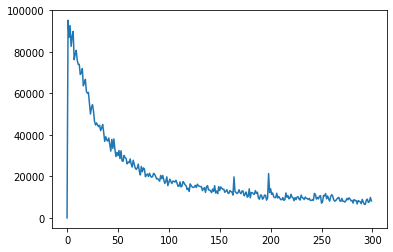

In [151]:
np_loss_list = []
loss_total_epoch = 0
for iterator, loss in enumerate(loss_list):
    loss_total_epoch += loss.detach().numpy()
    if iterator%len(train_loader) == 0:
        np_loss_list.append(loss_total_epoch)
        loss_total_epoch =0 

plt.plot(np_loss_list)
plt.show()



In [145]:
with torch.no_grad():
    classes = ['BSD_11', 'BSD_21', 'BSD_31', 'BSD_P1']
    
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(4)]
    n_class_samples = [0 for i in range(4)]
    n_class_samples_out = [0 for i in range(4)]
    for window, labels in test_loader:
        outputs = model(window.float())
        for i in range(batch_size):
            if len(labels)==4:
                label = labels[i]
                output = torch.argmax(outputs[i])
                if label == output:
                    n_correct+=1
                    n_class_correct[label]+=1

                n_samples+=1
                n_class_samples[label]+=1
                n_class_samples_out[output]+=1
            else:
                break
            
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 90.36458333333333 %
Accuracy of BSD_11: 86.91588785046729 %
Accuracy of BSD_21: 96.84210526315789 %
Accuracy of BSD_31: 84.46601941747574 %
Accuracy of BSD_P1: 94.9367088607595 %


In [147]:
print(n_class_samples_out)
print(n_class_samples)
print(n_class_correct)

[96, 117, 88, 83]
[107, 95, 103, 79]
[93, 92, 87, 75]


In [37]:
test_list = ['A', 'B']
test_string = "DES"

res = any(ele in test_string for ele in test_list)
print(res)

False


In [150]:
print(len(train_loader))

384


tensor([[-1.1688, -0.3698,  1.2154, -1.2929,  0.2711],
        [-1.4512, -0.5559,  0.1435, -2.4172,  0.3523],
        [ 0.8883, -0.0566,  0.8174,  1.0130,  1.3393]], requires_grad=True)


tensor([3, 1, 0])
